In [1]:
import os 
import glob
import pandas as pd

import cv2
import numpy as np



import torch

import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from torchsummary import summary
from sklearn.model_selection import train_test_split


from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

from dataload import xml_to_csv,PetData,Sub_region_train,Sub_region

from tqdm import tqdm
from utills import ssearch,misc
from utills.misc import create_label,balance_df

In [3]:
root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")

seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))  
## 

train, valid = train_test_split(balanced_df, test_size=0.3,random_state=seed)  
valid1,valid2 = train_test_split(valid, test_size=0.5,random_state=seed)  

BATCH_SIZE = 1
train_ds = PetData(train, train=True,raw_return=True)
valid_ds_1= PetData(valid1, train=True,raw_return=True)
valid_ds_2= PetData(valid2, train=True,raw_return=True)

def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=False)
valid_dl_1 = torch.utils.data.DataLoader(valid_ds_1, batch_size=BATCH_SIZE
                                   
                                         , collate_fn=collate_fn)

valid_dl_2 = torch.utils.data.DataLoader(valid_ds_2, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [4]:
df

,filename,target,xmin,ymin,xmax,ymax


In [5]:
import torch.optim as optim
#Loading Pretrained Network
model = models.alexnet(pretrained=True)
model.classifier[6]=nn.Linear(4096,3)
model.load_state_dict(torch.load("models/epoch_63"))

<All keys matched successfully>

# Training SVM

## Extracting Ground Truth Samples for Each Class


In [291]:
#for class
device="cuda"
def get_gt_ft(tgt_class,model,datasets,device):
    cnn_transforms=nn.Upsample((224,224))
    normalize=T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    model.eval()
    model.to(device)
    gt_fts=[]
    for dataset in datasets:
        for i,(img,bboxes) in  tqdm(enumerate(dataset)):
            for (x1,y1,x2,y2,label) in bboxes:
                if label==tgt_class:
                    
                    x1=np.clip(x1-16,0,img.shape[2])
                    y1=np.clip(y1-16,0,img.shape[1])
                    x2=np.clip(x2+16,0,img.shape[2])
                    y2=np.clip(y2+16,0,img.shape[1])
        
                    cropped_img=(img[:,int(y1):int(y2),int(x1):int(x2)])
                    cropped_img=normalize(cropped_img)
                    cropped_img=cnn_transforms(cropped_img.unsqueeze(0))
                    cropped_img=cropped_img.to(device)
                    gt_ft=model.classifier[0:-2](torch.flatten((model.avgpool(model.features(cropped_img))),1))
                    gt_fts.append(gt_ft.cpu())
                else:
                    continue
    gt_fts=torch.stack(gt_fts)
    return gt_fts

In [12]:
gt_ft_cats=get_gt_ft(0,model,[train_ds,valid_ds_1],"cuda")
torch.save(gt_ft_cats,"gtf_cats.pt")

gt_ft_dogs=get_gt_ft(1,model,[train_ds,valid_ds_1],"cuda")
torch.save(gt_ft_dogs,"gtf_dogs.pt")

1663it [00:32, 51.93it/s]
356it [00:06, 58.54it/s]
1663it [00:29, 56.07it/s]
356it [00:06, 51.21it/s]


## Negative Sampling

In [162]:
from metrics import iou
def neg_sample(proposed_regions,bboxes):
    ''' 
    if iou below 0.3 it is considered as negative sample for training SVM
    '''

    iou_threshold=0.3
    for region in proposed_regions:
        max_iou=-99
        region['labels']=-1
        region_tensor=torch.tensor((region['rect'][0],region['rect'][1],region['rect'][2],region['rect'][3]))
        for bbox in bboxes:
            box_tensor=torch.tensor((bbox[0],bbox[1],bbox[2],bbox[3]))
            cur_iou=iou.torch_getIOU(region_tensor,box_tensor)
            if max_iou<cur_iou:
                max_iou=cur_iou
        region['iou']=max_iou
    regions_df=pd.DataFrame.from_dict(proposed_regions)
    regions_df=regions_df[regions_df['iou']<iou_threshold]
    return regions_df

In [290]:
'''
device='cuda'
model.to(device)
model.eval()

x_ft=[]
y_label=[]    


for img_batch_idx,(img_tuple,bbox) in tqdm(enumerate(valid_ds_1)):
    acc_regions=None
    avg_tloss_pimage=0

    regions = ssearch.selective_search(img_tuple.numpy().transpose(1,2,0), scale=50, sigma=0.8, min_size=20)
    regions=neg_sample(regions,bbox)  #Consider IOU<0.3 as negative sapmle
    regions=regions.drop_duplicates(subset=['rect'])
    #Create Dataset of proposed regions
    region_ds=Sub_region(regions,img_tuple,pil=False)
    region_dl=DataLoader(region_ds,batch_size=128)
    with torch.no_grad():
        for batch_idx,(img_tuple,label) in enumerate(region_dl):
            img_tuple=img_tuple.to(device)
            ft_vec=model.classifier[0:-2](torch.flatten((model.avgpool(model.features(img_tuple))),1))
            output=model.classifier[-2:](ft_vec.clone())
            outmax=torch.max(output.data,1).indices.cpu()
            b = outmax != 0
            indices = b.nonzero()
            
            if (len(indices) !=0):                             #Cache False Positive as Hard Negative Sample
                sampled_fn=img_tuple[indices.reshape(-1)]
                out=ft_vec[indices.reshape(-1)].cpu().numpy()
                outmax=outmax[indices.reshape(-1)].numpy()
                x_ft.append(out)
                y_label.append(outmax)

    

x_ft=np.concatenate(x_ft)
y_label=np.concatenate(y_label)
np.save("D:/Dataset/Oxford/hard_negative_cat_1.npy",x_ft[np.where(y_label ==1)])
np.save("D:/Dataset/Oxford/hard_negative_dog_1.npy",x_ft[np.where(y_label ==2)])
'''
print("Negative Sampling")

357it [1:40:57, 16.97s/it]


## Train SVM for each_class

In [316]:
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

In [317]:
cat_pos=torch.load("gtf_cats.pt").squeeze(1).detach().numpy()
cat_neg=np.load("D:/Dataset/Oxford/hard_negative_cat_1.npy")

dog_pos=torch.load("gtf_dogs.pt").squeeze(1).detach().numpy()
dog_neg=np.load("D:/Dataset/Oxford/hard_negative_dog_1.npy")

In [318]:
x_data=np.concatenate([cat_pos,dog_pos,cat_neg,dog_neg])

In [319]:
y_data=np.concatenate([np.ones(cat_pos.shape[0]),np.ones(dog_pos.shape[0])*2,np.zeros(cat_neg.shape[0]),np.zeros(dog_neg.shape[0])])

In [321]:
start=time.time()
x_data,y_data = shuffle(x_data,y_data, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

clf_all = svm.SVC(kernel='linear',max_iter=5000,probability=True)
clf_all.fit(X_train, y_train)

print(classification_report(y_test, clf_all.predict(X_test)))


In [324]:
import pickle

filename = 'svm.sv'
pickle.dump(clf_all, open(filename, 'wb'))
svm = pickle.load(open("svm.sv", 'rb'))



# Evaluating/Testing Model  (We are nearly there!!)

0it [00:00, ?it/s]

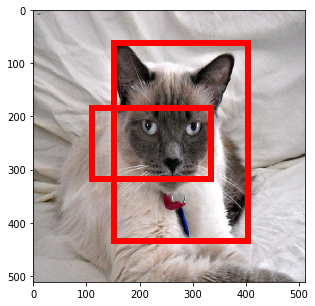

20it [12:56, 47.89s/it]

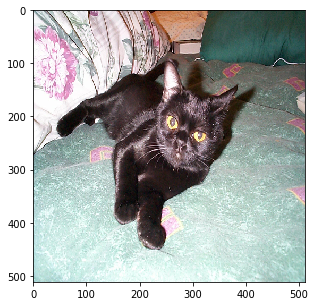

40it [27:07, 54.78s/it]

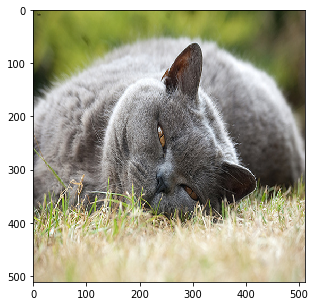

60it [40:56, 33.34s/it]

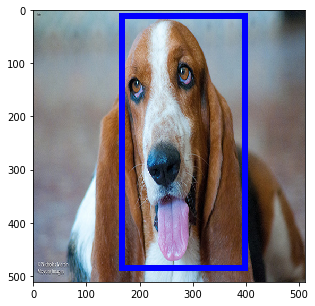

80it [54:30, 49.31s/it]

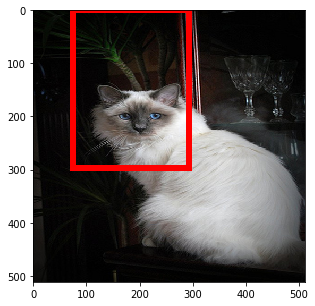

100it [1:08:03, 44.77s/it]

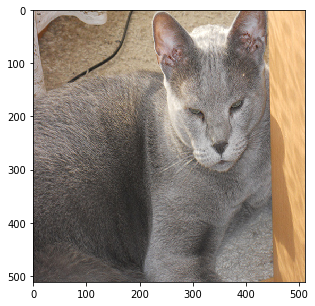

120it [1:23:01, 47.10s/it]

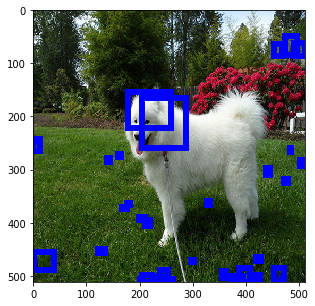

140it [1:34:55, 35.82s/it]

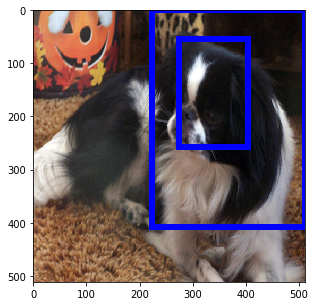

160it [1:46:50, 31.17s/it]

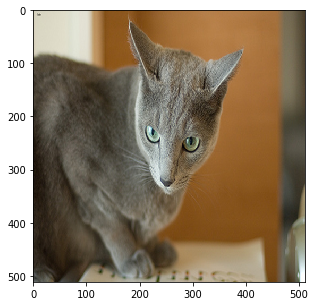

180it [2:00:26, 56.48s/it]

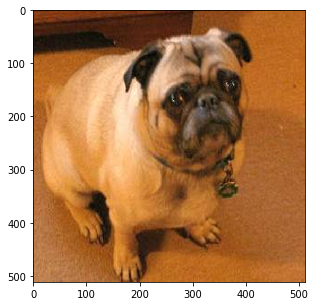

200it [2:15:42, 52.50s/it]

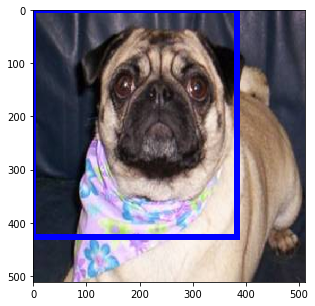

220it [2:29:22, 49.14s/it]

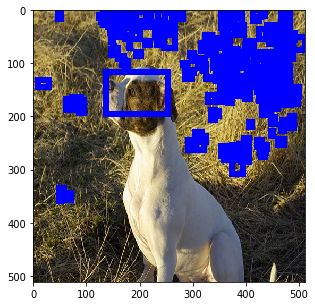

240it [2:43:10, 39.36s/it]

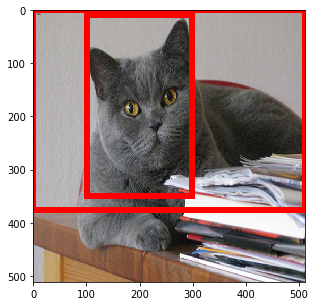

260it [2:57:11, 32.35s/it]

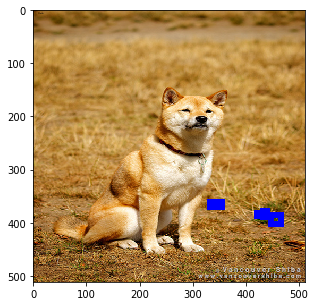

280it [3:12:18, 49.82s/it]

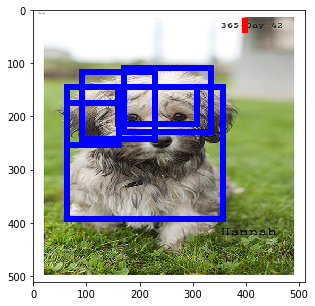

300it [3:23:55, 31.56s/it]

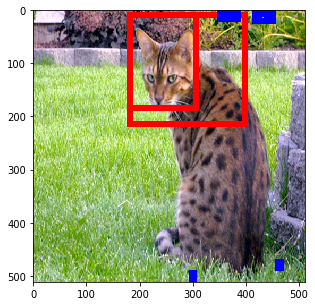

320it [3:38:34, 42.93s/it]

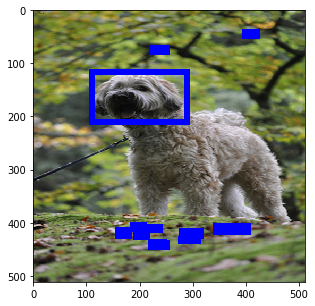

340it [3:52:32, 44.84s/it]

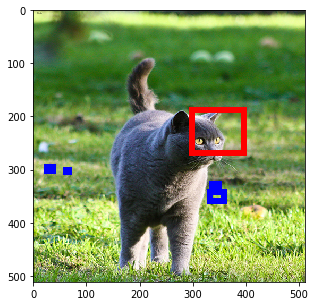

357it [4:03:11, 40.87s/it]

Done


In [364]:
MAX_BOX=1
device="cuda"
model.eval()

model.to(device)
COLOR=['_','red','blue']
nms_thresh=0.5

debug_dog=[]
for img_batch_idx,(img_tuple,_) in tqdm(enumerate(valid_ds_2)):
    acc_regions=None
    avg_tloss_pimage=0

    regions = ssearch.selective_search(img_tuple.numpy().transpose(1,2,0), scale=50, sigma=0.8, min_size=20)
    for region in regions:
        region['labels']=-1
    regions=pd.DataFrame.from_dict(regions)
    
    #Create Dataset of proposed regions
    region_ds=Sub_region(regions,img_tuple,pil=False,return_idx=True)
    region_dl=DataLoader(region_ds,batch_size=128)  

    
    detected_region_idx=[]
    conf_score=[]
    labels=[]
    with torch.no_grad():
        region_idx=0
        for batch_idx,(region_tuple,_,ds_index) in enumerate(region_dl):
            region_tuple=region_tuple.to(device)
            ft_vec=model.classifier[0:-2](torch.flatten((model.avgpool(model.features(region_tuple))),1)).cpu().numpy()
            pred=clf_all.predict(ft_vec)
            debug_dog.append(pred)
            prob=clf_all.predict_proba(ft_vec)
        
            for idx,(a,b) in enumerate(zip(pred,prob)):
                if a:
                    detected_region_idx.append(ds_index[idx].item())        
                    conf_score.append(b[int(a)])
                    labels.append(int(a))
                   
    det_region=regions.iloc[detected_region_idx].reset_index()
    det_region['conf_score']=conf_score
    det_region['labels']=labels
    
    det_region=det_region.sort_values(["conf_score"], ascending = False)
    det_region.drop_duplicates(subset ="rect", keep = False, inplace = True)
    det_region = det_region.drop(det_region[det_region.conf_score < 0.5].index)
    
    final_df=None
    class_df = det_region.groupby('labels')    
    dfs=[class_df.get_group(x) for x in class_df.groups]

    for df in dfs:
        idx=0
        while True:
            if idx==len(df):
                break
            anc_box=df.iloc[idx].rect
            flag=[False]*len(df)
            for row_idx_2 in range(idx+1,len(df)):
                if iou.torch_getIOU(anc_box,df.iloc[row_idx_2].rect) > nms_thresh:
                    flag[row_idx_2]=True
            df=df.drop(df.index[np.where(flag)[0]])

            idx+=1

        if final_df is None:
            final_df=df
        else:
            final_df=final_df.append(df)
    if img_batch_idx%20==0:
        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(img_tuple.numpy().transpose((1,2,0)))
        if final_df is not None:
            for data in final_df.iterrows():
              #  print(data)
                rect=data[1]['rect']
                xy=rect[0],rect[1]
                width=rect[2]-rect[0]
                height=rect[3]-rect[1]

                ax.add_patch(
                 patches.Rectangle(
                    xy,
                    width,
                    height,
                    edgecolor = COLOR[data[1]["labels"]],
                    fill=False,
                    linewidth=6,))
        plt.show()
    if final_df is not None:
        final_df.to_csv(f'result/{img_batch_idx:04}.csv',index=False)
    if final_df is  None:
        final_df=pd.DataFrame(columns=['index','rect','labels','conf_score'])
        final_df.to_csv(f'result/{img_batch_idx:04}.csv',index=False)


print("Done")

In [369]:
result_list=glob.glob("result/*.csv")

In [370]:
len(result_list)

357

In [376]:
count=0
for result_path in result_list:
    result=pd.read_csv(result_path)
    if len(result)==0:
        count =count+1
    

In [377]:
count

73